<a href="https://colab.research.google.com/github/abhishek-parashar/style-gan/blob/master/encoder_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start: To run this demo StyleGAN code, make a local copy of this notebook in your drive!

## Before you move on, make sure you have GPU acceleration enabled:
> ### Click 'Runtime' in the menu tab at the top
> ### Click 'Change runtime type'
> ### Make sure the hardware accelerator is set to 'GPU'

1. Upgrade tqdm:

In [1]:
!pip install --upgrade tqdm

     |████████████████████████████████| 61kB 2.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


2. Restart the Python kernel to load the updated version:

In [0]:
import os 
os.kill(os.getpid(), 9)

## Now we can start for real:
### Let's first clone the Github repo we'll use: https://github.com/pbaylies/stylegan-encoder

In [0]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

fatal: destination path 'stylegan-encoder' already exists and is not an empty directory.


### cd into the repo folder: (run this cell only once)

In [0]:
cd stylegan-encoder

/content/stylegan-encoder


### Let's see the files inside the repo we just cloned:

In [0]:
ls

adaptive.py                            Play_with_latent_directions.ipynb
aligned_images/                        pretrained_example.py*
align_images.py                        raw_images/
config.py*                             README.md*
dataset_tool.py*                       requirements.txt
dnnlib/                                robust_loss/
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


### create folder for images.

In [0]:
rm -rf aligned_images raw_images

In [0]:
mkdir aligned_images raw_images

# I. Get Images:

## Some tips for the images:


*   Use HD images (preferably > 1000x1000 pixels)
*   Make sure your face is not too small
*   Neutral expressions & front facing faces will give better results
*   Clear, uniform lighting conditions are also recommened



## Option 1: Upload Images manually (usually gives the best results)



*   Click the '>' icon in the panel on the top left 
*   Go to the 'Files' tab
*   Unfold the stylegan-encoder folder (left-click)
*   Right click the 'stylegan-encoder/raw_images' folder and click "upload"
*   I'd recommend starting with 3 - 6 different images containing faces



## Let's check the contents of our image folder before we start:
#### (You can always manually delete images by right clicking on them in the file tab)

In [0]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

FileNotFoundError: ignored

## Make sure we're using the right TensorFlow version (1.15):

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


# II. Auto-Align faces:
### This script wil:


1.   Look for faces in the images
2.   Crop out the faces from the images
3.   Align the faces (center the nose and make the eyes horizontal)
4.   Rescale the resulting images and save them in "aligned_images" folder

### The cell below takes about a minute to run



In [0]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 2s 0us/step
Aligning kareena-kapoor-red-lips-HD.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/kareena-kapoor-red-lips-HD_01.png
Aligning Kareena 3.JPG ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Kareena 3_01.png
Aligning 4k-natalie-portman-2q.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/4k-natalie-portman-2q_01.png
Aligning scarlett-johansson.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/scarlett-johansson_01.png
Aligning Kiara-Advani-HD-Wallpapers-5.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Kiara-Advani-HD-Wallpapers-5_01.png
Aligning Scarlett-Johansson-HD-Wallpaper.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Scarlett-Johansson-HD-Wallpaper_01.png
Aligning iuaiPiwH.jpeg ...
Gett

## Let's take a look at our aligned images:

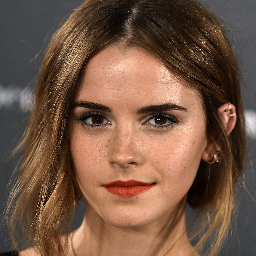

'img 0: emma_01.png'

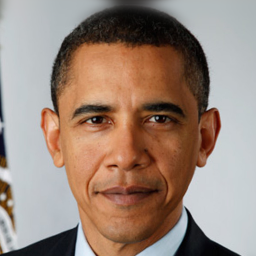

'img 1: obama_01.png'

In [0]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

# Important, before moving on:
### Manually clean the 'aligned_images' directory

> ### 1. Manually remove all 'bad' images that are not faces / don't look sharp / clear 
> #####  (Use the image names from the plots above to guide you)
> ### 2. Make sure you don't have too many faces in this folder (8 at most preferably)




# Encoding faces into StyleGAN latent space:

## We'll be using pbaylies' awesome encoder repo (building on original work from Puzer): https://github.com/pbaylies/stylegan-encoder


## First, let's download a pretrained resnet encoder: 
### --> This model takes an image as input and estimates the corresponding latent code

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:05, 64.9MB/s]


# III. The actual encoding process:
> #### Highly recommended: play with the encoding params: they have a huge effect on the latent representations & images!
> #### Extra encoding options: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py

#### Note: This script will also download:


*   The pretrained StyleGAN network from NVIDIA trained on faces
*   A pretrained VGG-16 network, trained on ImageNet

#### After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!
#### Note that by default, we're optimizing w vectors, not z-vectors!


In [0]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 2 images ready for encoding!
Recommended batch_size for the encode_images process: 2


#### Important: to avoid issues, set the batch_size argument lower than or equal to the number of aligned_images (see previous cell)
> Keep batch_size<8 or the GPU might run out of memory

### Depending on the settings, the encoding process might take a few minutes...

## Fast version:

In [0]:
!python encode_images.py --optimizer=lbfgs --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")

## Slow version:

In [0]:
!python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








  0% 0/2 [00:00<?, ?it/s]Loading mask masks/emma_01.png
Loading ResNet Model:






  0% 0/400 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:292: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

emma_01: loss 143.6065; lr 0.0200:   0% 0/400 [00:06<?, ?it/s]
emma_01: loss 143.6065; lr 0.0200:   0% 1/400 [00:07<48:46,  7.33s/it]
emma_01: loss 155.7035; lr 0.0200:   0% 1/400 [00:07<48:46,  7.33s/it]
emma_01: loss 155.7035; lr 0.0200:   0% 2/400 [00:07<34:53,  5.26s/it]
emma_01: loss 143.1062; lr 0.0200:   0% 2/400 [00:08<34:53,  5.26s/it]
emma_01: loss 143.1062; lr 0.0200:   1% 3/400 [00:08<25:12,  3.81s/it]
emma_01: loss 131.6271; lr 

## Showtime!
### Let's load the StyleGAN network into memory:

In [0]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")







Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let's plot some random StyleGAN samples:

In [0]:
plot_imgs(averaged_generator_network, 3, 3)

# Let's take a look at the results of our encoding:
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 500)
> 2. Decrease the L1 penalty (to eg 0.15)
> 3. Try a lower initial learning rate (eg 0.02) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
> 5. You can find a bunch of good presets on the repo documentation: https://github.com/pbaylies/stylegan-encoder

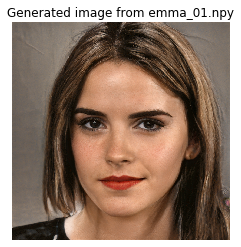

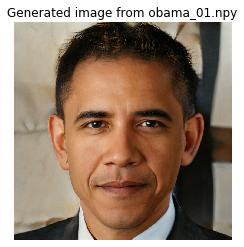

In [0]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

## Let's compare our encoded samples with the original ones:

**Note: when you optimized with the setting --face_mask=True, the hair will be copied from the source images. If you don't want this, optimize without that setting!**

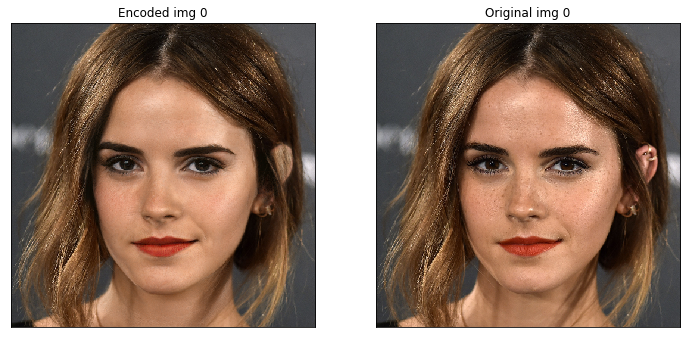

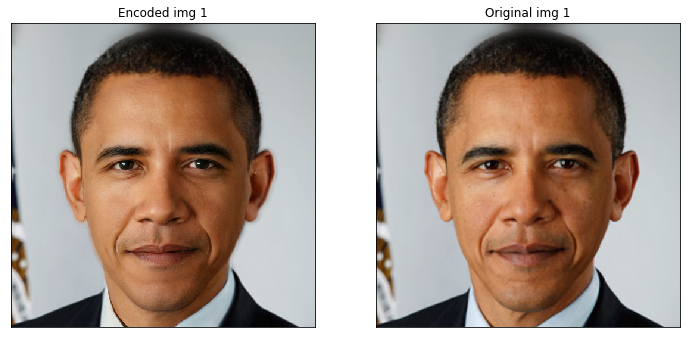

In [0]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

# IV. Cherry pick images & dump their latent vectors to disk
### Manipulating latent vectors (Notebook II) is tricky and will only work well if the face encoding looks 'good'
### Cherry pick a few images where the optimization worked well
> (Use the image indices from the plot titles above)

In [0]:
good_images = [0,1]  #Change these numbers to pick out latents that worked well (see the image plots)

## Save these latent vectors to disk:

In [0]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


# V. Manipulating the faces
### Everything we downloaded / saved to disk is currently on a temporary VM running on Google Colab
> We'll want to reuse the latent vectors later, so you should download them manually:
>> * Go to the root directory using the Files browser
>> * Richt-click & Download the latent representations: "output_vectors.npy"
## Next, let's continue with notebook II:
> ### Simply open the second notebook from the Drive folder and continue the guide-steps
> ### (Hint: Notebook II is where all the fun is!)

![alt text](https://66.media.tumblr.com/tumblr_mc3hg5VpQP1qcy0p7o1_400.gif)